# Assignment 3

**Submission deadlines:**

  - Tuesday groups: 22.04.2025
  - Friday groups: 18.04.2025

**Points:** Aim to get 10 points + 4 extra

## Submission instructions
The class is held on-site in lab rooms. Please prepare you notebook on your computer or anywhere in the cloud (try using DeepNote or Google Colab).

Make sure you know all the questions and answers, and that the notebook contains results; before presentation do `Runtime -> Restart and run all`

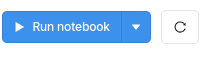

We provide starter code, however you are not required to use it as long as you properly solve the tasks.

# Classify the Oxford Flowers dataset (Weight & Biases) [6p]

In this task, you will train a convolutional neural network to classify images of flowers from the [Oxford Flowers 102 dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/). The dataset consists of 102 flower categories, and each class has between 40 and 258 images. The images have large scale, pose, and light variations. In addition, there are categories that have large variations within the category and several very similar categories.

    
The dataset is available in `torchvision.datasets.Flowers102` class; see [Flowers102.html](https://pytorch.org/vision/main/generated/torchvision.datasets.Flowers102.html). You can use the following code to load the dataset:

```python
import torchvision
import torchvision.transforms as transforms

dataset = torchvision.datasets.Flowers102(root='./data', download=True, transform=transforms.ToTensor())
```

**Hint**: The default split of the dataset is 1020, 1020 and 6149 images for training, validation and test sets respectively.
If you can handle the bigger training dataset, you can experiment by taking up to 80% of the test set for training.


In this task you should run several experiments to classify the images.
In order to track the experiments, you can use the `Weight & Biases` library; see the [documentation](https://docs.wandb.ai/quickstart) for more details.

Implement your code as a single Python script or a Jupyter notebook. Remember to log the experiment configuration, hyperparameters, and results (e.g., training loss, validation loss, accuracy and test loss, accuracy).
For logging, you can use the `wandb.log` function to log the metrics and hyperparameters. You can also log the model architecture, training curves, and other relevant information.

* 1. **[1p]**:
    * Your task is to implement a convolutional neural network from scratch using PyTorch.
    * Your CNN should consist of convolutional layers (Conv2D), pooling layers (MaxPooling2D), activation layers (e.g., ReLU), and fully connected layers (if needed).
    
* 2. **[2p]**:
    * Train your CNN on different training set sized (10%, 20%, 50%, 80%, 100%) and evaluate the performance on the validation set and test set.
        * Report the accuracy and loss on the validation set and test set for each training set size.
    * Train your CNN on the full training set plus 20%, 50% and 80% of the test set and evaluate the performance on the validation set and the remaining test set.
        * Report the accuracy and loss on the validation set and remaining test set for each training set size.
    * Compare the performance of your CNN on the different training set sizes and analyze the results.

* 3. **[1p]**:
    * Implement a baseline AlexNet model using PyTorch.
    * Training AlexNet may take a long time, so try to use GPU acceleration if available.

* 4. **[1p]**:
    * Input normalization: experiment with different input normalization techniques (e.g., mean subtraction, standardization) and analyze their impact on the model's performance.

* 5. **[2p]**:
    * Experiment with different hyperparameters such as learning rate, batch size, number of epochs, and optimizer choice (e.g., SGD, Adam).

* 6. **[2p]**:
    * Modify your CNN architecture to include batch normalization and dropout layers.
    * Experiment with different dropout rates and analyze their impact on the model's performance.

* 7. **[1p]**:
    * Implement data augmentation techniques such as random rotations, shifts, flips, and zooms on the training dataset.
    * Train your CNN with augmented data and compare the performance with the baseline model trained on the original data.

* 8. ***[2p extra points]***:
    * Implement residual connections in your CNN architecture; see the [ResNet paper](https://arxiv.org/abs/1512.03385) for more details.
    * Implement inception modules in your CNN architecture; see the [GoogLeNet paper](https://arxiv.org/abs/1409.4842) for more details.
                

Analyze the results obtained from different experiments.
Discuss the effects of varying training set size, hyperparameters, batch normalization, dropout, and data augmentation on the CNN's performance.
Provide insights into how these factors influence model training, convergence, and generalization.

Use the `Weight & Biases` reports to present your findings in a comprehensive report or presentation; see the [documentation](https://docs.wandb.ai/quickstart) for more details.

**[2p extra]**: present your findings (for each task) in a report format in Weight & Biases.




# Initialization

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset, ConcatDataset
import numpy as np
import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utils

In [ ]:
def create_subset(dataset, percentage, seed=42):
    """Create reproducible subset"""
    np.random.seed(seed)
    size = int(len(dataset) * percentage)
    indices = np.random.choice(len(dataset), size, replace=False)
    return Subset(dataset, indices)

def print_dataset_sizes(train, val, test):
    print(f"Training samples: {len(train):,}")
    print(f"Validation samples: {len(val):,}")
    print(f"Test samples: {len(test):,}\n")

def split_dataset(dataset, train_ratio=0.8, seed=42):
    """Guarantees non-overlapping splits"""
    np.random.seed(seed)
    indices = np.random.permutation(len(dataset))
    split_idx = int(len(dataset) * train_ratio)
    return (
        Subset(dataset, indices[:split_idx]),  # Train portion
        Subset(dataset, indices[split_idx:])   # Test portion
    )

## Model training

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
def train_model(model, optimizer, train_loader, val_loader, test_loader, experiment_name, group, config, criterion=nn.CrossEntropyLoss(), additional_tags=[]):
    """
    Args:
        train_loader (DataLoader): Training data loader
        val_loader (DataLoader): Validation data loader
        test_loader (DataLoader): Test data loader
        experiment_name (str): Identifier for weights and biases
        group (str): Experiment group name
        config (dict): Experiment configuration - hyperparameters
        criterion (nn.Module): Loss function
        additional_tags (list): Additional tags for weights and biases
    """

    print(config)

    wandb.init(
        project="flowers102-classification",
        config=config,
        name=experiment_name,
        group=group,
        tags=["manual_run", experiment_name] +additional_tags
    )
    model = model.to(device)

    best_val_acc = 0.0
    early_stop_counter = 0
    early_stop_patience = config.get('early_stop_patience', 10)

    for epoch in range(wandb.config.epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        avg_train_loss = train_loss / len(train_loader)

        val_loss, val_acc = evaluate(model, val_loader, criterion)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stop_counter = 0
            torch.save(model.state_dict(), f"best_model_{experiment_name}.pth")
        else:
            early_stop_counter += 1

        wandb.log({
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "best_val_acc": best_val_acc
        })

        print(f"Epoch {epoch+1}/{wandb.config.epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        if early_stop_counter >= early_stop_patience:
            print(f"Early stopping triggered at epoch {epoch+1}!")
            break

    test_loss, test_acc = evaluate(model, test_loader, criterion)
    wandb.log({
        "final_test_loss": test_loss,
        "final_test_acc": test_acc
    })

    print(f"\nExperiment '{experiment_name}' completed:")
    print(f"Best Val Acc: {best_val_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    wandb.finish()
    return test_acc

## Model evaluation

In [ ]:
def evaluate(model, loader, criterion):
    """
    Args:
        model (nn.Module): Trained model
        loader (DataLoader): Data loader for evaluation
        criterion: Loss function

    Returns:
        tuple: (average_loss, accuracy)
    """

    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

## AlexNet baseline model

In [ ]:
class AlexNet(nn.Module):
    def __init__(self,num_classes = 102, dropout=0.5):
        super(AlexNet,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3,96, kernel_size=11,stride=4,padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2))

        self.layer2 = nn.Sequential(
                nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))

        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(6400, 4096),
            nn.ReLU())

        self.fc1 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(4096, 4096),
            nn.ReLU())

        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)

        out = out.reshape(out.size(0), -1)

        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

## Base configs

In [ ]:
base_config_sgd = {
    'epochs': 25,
    'early_stop_patience': 5,
    'batch_size': 128,
    'learning_rate': 1e-3,
    'momentum': 0.9,
    'weight_decay': 0,
    'dropout_p': 0.5,
}

base_config_adam = {
    'epochs': 25,
    'early_stop_patience': 5,
    'batch_size': 128,
    'learning_rate': 1e-3,
    'weight_decay': 0,
    'dropout_p': 0.5,
}

base_transform_alex = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

base_train_alex = datasets.Flowers102(root='./data', split='train', transform=base_transform_alex, download=True)
base_val_alex = datasets.Flowers102(root='./data', split='val', transform=base_transform_alex)
base_test_alex = datasets.Flowers102(root='./data', split='test', transform=base_transform_alex)

base_train_loader_alex = DataLoader(base_train_alex, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
base_val_loader_alex = DataLoader(base_val_alex, batch_size=128, num_workers=2, pin_memory=True)
base_test_loader_alex = DataLoader(base_test_alex, batch_size=128, num_workers=2, pin_memory=True)

100%|██████████| 345M/345M [00:15<00:00, 22.1MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.06MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 23.0MB/s]


# Solutions

## Problem 1,2

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

full_train = datasets.Flowers102(root='./data', split='train',
                               transform=train_transform, download=True)
val_set = datasets.Flowers102(root='./data', split='val',
                            transform=train_transform)
full_test = datasets.Flowers102(root='./data', split='test',
                              transform=train_transform)

In [ ]:
class FlowerCNN(nn.Module):
    def __init__(self, num_classes=102):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((7, 7))
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*7*7, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [ ]:
base_config = {
    'learning_rate': 0.001,
    'epochs': 20,
    'batch_size': 32
}

exp1_train = create_subset(full_train, 1)
exp1_test = full_test
print_dataset_sizes(exp1_train, val_set, exp1_test)
model = FlowerCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=base_config['learning_rate'])

# ! Execute with:
# train_model(model,
#            DataLoader(exp1_train, batch_size=32, shuffle=True),
#            optimizer,
#            DataLoader(val_set, batch_size=32),
#            DataLoader(exp1_test, batch_size=32),
#            "100%",
#            base_config)

test_train, test_test = split_dataset(full_test, train_ratio=0.8)
exp2_train = ConcatDataset([full_train, test_train])
exp2_test = test_test
print_dataset_sizes(exp2_train, val_set, exp2_test)

# ! Execute with:
# train_model(model,
#            optimizer,
#            DataLoader(exp2_train, batch_size=32, shuffle=True),
#            DataLoader(val_set, batch_size=32),
#            DataLoader(exp2_test, batch_size=32),
#            '100%+50%test',
#             base_config)

Training samples: 1,020
Validation samples: 1,020
Test samples: 6,149

Training samples: 5,939
Validation samples: 1,020
Test samples: 1,230



# Testing Hyperparameters

## Learning rate

In [ ]:
learning_rates = [1e-1, 1e-2, 1e-3]
learning_rates_adam = [1e-3, 1e-4, 1e-5]
learning_rates_longer = [1e-2, 1e-3]
learning_rates_adam_longer = [1e-3, 1e-4, 1e-5]

lr_experiments = []
for lr in learning_rates:
    lr_config = base_config_sgd.copy()
    lr_config['learning_rate'] = lr
    lr_experiments.append({
        'experiment_name': f'Alex_lr_{lr}',
        'group': 'learning_rate',
        'additional_tags': ['lr_test'],
        'lr_config': lr_config,
        })


# Adam lr_experiments
lr_adam_experiments = []
for lr in learning_rates_adam:
    lr_config = base_config_adam.copy()
    lr_config['learning_rate'] = lr
    lr_adam_experiments.append({
        'experiment_name': f'Alex_lr_adam_{lr}',
        'group': 'learning_rate',
        'additional_tags': ['lr_test', 'adam'],
        'lr_config': lr_config,
        })


# lr_experiments for 50 max epochs
lr_more_epochs_experiments = []
for lr in learning_rates_longer:
    lr_config = base_config_sgd.copy()
    lr_config['learning_rate'] = lr
    lr_config['epochs'] = 50
    lr_more_epochs_experiments.append({
        'experiment_name': f'Alex_lr_longer_{lr}',
        'group': 'learning_rate',
        'additional_tags': ['lr_test', 'longer'],
        'lr_config': lr_config,
        })

# lr_adam_experiments for 50 max epochs
lr_adam_more_epochs_experiments = []
for lr in learning_rates_adam_longer:
    lr_config = base_config_adam.copy()
    lr_config['learning_rate'] = lr
    lr_config['epochs'] = 50
    lr_adam_more_epochs_experiments.append({
        'experiment_name': f'Alex_lr_adam_longer_{lr}',
        'group': 'learning_rate',
        'additional_tags': ['lr_test', 'adam', 'longer'],
        'lr_config': lr_config,
        })

## Dropout rate

In [ ]:
# As of findings from Learning rate
base_config_adam['learning_rate']=1e-4
base_config_adam['epochs']=50

dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.5, 0.6, 0.75]

dr_experiments = []
for dr in dropout_rates:
    dr_config = base_config_adam.copy()
    dr_config['dropout_p'] = dr
    dr_experiments.append({
        'experiment_name': f'Alex_dropout_{dr}',
        'group': 'dropout',
        'additional_tags': ['dropout_test'],
        'model': model,
        'optimizer': optimizer,
        'dr_config': dr_config,
        })

## Weight decay

In [ ]:
# As of findings from Dropout rate
base_config_adam['weight_decay'] = 1e-3
base_config_adam['epochs'] = 100
base_config_adam['early_stop_patience']= 10

weight_decays = [0.1, 0, 1e-2, 1e-3, 1e-4]

wd_experiments = []
for wd in weight_decays:
    wd_config = base_config_adam.copy()
    wd_config['weight_decay'] = wd
    wd_experiments.append({
        'experiment_name': f'Alex_wd_{wd}',
        'group': 'weight_decay',
        'additional_tags': ['wd_test'],
        'model': model,
        'optimizer': optimizer,
        'wd_config': wd_config,
        })

# Data augmentation

In [ ]:
# As of weight decay findings
base_config_adam['weight_decay'] = 1e-2

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

augmented_train_alex = datasets.Flowers102(root='./data', split='train', transform=train_transform, download=True)
augmented_train_loader_alex = DataLoader(augmented_train_alex, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

# Experiments

In [ ]:
experiments_config = {
    'lr_test': False,
    'lr_adam_test': False,
    'lr_more_epochs_test': False,
    'lr_adam_more_epochs_test': False,
    'dropout_test': False,
    'weight_decay_test': False,
    'data_augmentation': True
}

if experiments_config['lr_test']:
    for exp in lr_experiments:
        model = AlexNet().to(device)
        optimizer = optim.SGD(model.parameters(),
                              lr=exp['lr_config']['learning_rate'],
                              weight_decay=exp['lr_config']['weight_decay'],
                              momentum=exp['lr_config']['momentum'])
        train_model(model,
                    optimizer,
                    base_train_loader_alex,
                    base_val_loader_alex,
                    base_test_loader_alex,
                    exp['experiment_name'],
                    exp['group'],
                    exp['lr_config'],
                    additional_tags=exp['additional_tags'])
        del model, optimizer
        torch.cuda.empty_cache()

if experiments_config['lr_adam_test']:
    for exp in lr_adam_experiments:
        model = AlexNet().to(device)
        optimizer = optim.Adam(model.parameters(),
                               lr=exp['lr_config']['learning_rate'],
                               weight_decay=exp['lr_config']['weight_decay'])
        train_model(model,
                    optimizer,
                    base_train_loader_alex,
                    base_val_loader_alex,
                    base_test_loader_alex,
                    exp['experiment_name'],
                    exp['group'],
                    exp['lr_config'],
                    additional_tags=exp['additional_tags'])
        del model, optimizer
        torch.cuda.empty_cache()

if experiments_config['lr_more_epochs_test']:
    for exp in lr_more_epochs_experiments:
        model = AlexNet().to(device)
        optimizer = optim.SGD(model.parameters(),
                              lr=exp['lr_config']['learning_rate'],
                              weight_decay=exp['lr_config']['weight_decay'],
                              momentum=exp['lr_config'].get('momentum', 0.9))
        train_model(model,
                    optimizer,
                    base_train_loader_alex,
                    base_val_loader_alex,
                    base_test_loader_alex,
                    exp['experiment_name'],
                    exp['group'],
                    exp['lr_config'],
                    additional_tags=exp['additional_tags'])
        del model, optimizer
        torch.cuda.empty_cache()

if experiments_config['lr_adam_more_epochs_test']:
    for exp in lr_adam_more_epochs_experiments:
        model = AlexNet(dropout=exp['lr_config']['dropout_p']).to(device)
        optimizer = optim.Adam(model.parameters(),
                               lr=exp['lr_config']['learning_rate'],
                               weight_decay=exp['lr_config']['weight_decay'])
        train_model(model,
                    optimizer,
                    base_train_loader_alex,
                    base_val_loader_alex,
                    base_test_loader_alex,
                    exp['experiment_name'],
                    exp['group'],
                    exp['lr_config'],
                    additional_tags=exp['additional_tags'])
        del model, optimizer
        torch.cuda.empty_cache()

if experiments_config['dropout_test']:
    for exp in dr_experiments:
        model = AlexNet(dropout=exp['dr_config']['dropout_p']).to(device)
        optimizer = optim.Adam(model.parameters(),
                               lr=exp['dr_config']['learning_rate'],
                               weight_decay=exp['dr_config']['weight_decay'])
        train_model(model,
                    optimizer,
                    base_train_loader_alex,
                    base_val_loader_alex,
                    base_test_loader_alex,
                    exp['experiment_name'],
                    exp['group'],
                    exp['dr_config'],
                    additional_tags=exp['additional_tags'])
        del model, optimizer
        torch.cuda.empty_cache()

if experiments_config['weight_decay_test']:
    for exp in wd_experiments:
        model = AlexNet(dropout=exp['wd_config']['dropout_p']).to(device)
        optimizer = optim.Adam(model.parameters(),
                               lr=exp['wd_config']['learning_rate'],
                               weight_decay=exp['wd_config']['weight_decay'])
        train_model(model,
                    optimizer,
                    base_train_loader_alex,
                    base_val_loader_alex,
                    base_test_loader_alex,
                    exp['experiment_name'],
                    exp['group'],
                    exp['wd_config'],
                    additional_tags=exp['additional_tags'])
        del model, optimizer
        torch.cuda.empty_cache()

if experiments_config['data_augmentation']:
    model = AlexNet(dropout=base_config_adam['dropout_p']).to(device)
    optimizer = optim.Adam(model.parameters(),
                            lr=base_config_adam['learning_rate'],
                            weight_decay=base_config_adam['weight_decay'])
    train_model(model,
                optimizer,
                augmented_train_loader_alex,
                base_val_loader_alex,
                base_test_loader_alex,
                'Alex_data_augmentation',
                'data_augmentation',
                base_config_adam,
                additional_tags=['data_augmentation'])
    del model, optimizer
    torch.cuda.empty_cache()

    model = AlexNet(dropout=base_config_adam['dropout_p']).to(device)
    optimizer = optim.Adam(model.parameters(),
                            lr=base_config_adam['learning_rate'],
                            weight_decay=base_config_adam['weight_decay'])
    train_model(model,
                optimizer,
                base_train_loader_alex,
                base_val_loader_alex,
                base_test_loader_alex,
                'Alex_data_augmentation_no_aug',
                'data_augmentation',
                base_config_adam,
                additional_tags=['data_augmentation', 'no_aug'])
    del model, optimizer
    torch.cuda.empty_cache()



{'epochs': 50, 'early_stop_patience': 5, 'batch_size': 128, 'learning_rate': 0.0001, 'weight_decay': 0, 'dropout_p': 0.3}


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: andrzej-pijanowski (andrzej-pijanowski-uniwroc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/50 | Train Loss: 4.6527 | Train Acc: 1.18% | Val Loss: 4.5909 | Val Acc: 4.71%
Epoch 2/50 | Train Loss: 4.2130 | Train Acc: 6.27% | Val Loss: 4.2529 | Val Acc: 8.14%
Epoch 3/50 | Train Loss: 3.7155 | Train Acc: 13.33% | Val Loss: 3.8558 | Val Acc: 12.25%
Epoch 4/50 | Train Loss: 3.2663 | Train Acc: 20.00% | Val Loss: 3.6112 | Val Acc: 12.06%
Epoch 5/50 | Train Loss: 2.9128 | Train Acc: 27.35% | Val Loss: 3.5318 | Val Acc: 16.18%
Epoch 6/50 | Train Loss: 2.5877 | Train Acc: 33.04% | Val Loss: 3.1361 | Val Acc: 21.96%
Epoch 7/50 | Train Loss: 2.2341 | Train Acc: 42.35% | Val Loss: 2.9927 | Val Acc: 26.27%
Epoch 8/50 | Train Loss: 1.8582 | Train Acc: 53.24% | Val Loss: 2.8913 | Val Acc: 28.63%
Epoch 9/50 | Train Loss: 1.5323 | Train Acc: 62.16% | Val Loss: 2.8478 | Val Acc: 30.39%
Epoch 10/50 | Train Loss: 1.2690 | Train Acc: 68.33% | Val Loss: 2.9729 | Val Acc: 30.39%
Epoch 11/50 | Train Loss: 1.0463 | Train Acc: 74.12% | Val Loss: 2.8119 | Val Acc: 32.55%
Epoch 12/50 | Train Los

best_val_acc,▁▂▂▂▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█████████████
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
final_test_acc,▁
final_test_loss,▁
train_acc,▁▁▂▂▃▃▄▅▅▆▆▇▇▇███████████████████████
train_loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▂▂▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█████████████
val_loss,█▇▆▅▄▃▃▂▂▃▂▂▂▁▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,48.13725
epoch,36
final_test_acc,41.19369


{'epochs': 50, 'early_stop_patience': 5, 'batch_size': 128, 'learning_rate': 0.0001, 'weight_decay': 0.01, 'dropout_p': 0.3}


Epoch 1/50 | Train Loss: 4.6693 | Train Acc: 1.76% | Val Loss: 4.6044 | Val Acc: 4.12%
Epoch 2/50 | Train Loss: 4.2725 | Train Acc: 6.18% | Val Loss: 4.3250 | Val Acc: 7.35%
Epoch 3/50 | Train Loss: 3.7824 | Train Acc: 12.06% | Val Loss: 3.9334 | Val Acc: 7.55%
Epoch 4/50 | Train Loss: 3.3486 | Train Acc: 19.51% | Val Loss: 3.6342 | Val Acc: 12.06%
Epoch 5/50 | Train Loss: 2.9909 | Train Acc: 24.61% | Val Loss: 3.3395 | Val Acc: 18.92%
Epoch 6/50 | Train Loss: 2.6437 | Train Acc: 32.65% | Val Loss: 3.3255 | Val Acc: 16.67%
Epoch 7/50 | Train Loss: 2.3447 | Train Acc: 39.71% | Val Loss: 3.2211 | Val Acc: 20.78%
Epoch 8/50 | Train Loss: 2.0393 | Train Acc: 47.25% | Val Loss: 2.9631 | Val Acc: 26.27%
Epoch 9/50 | Train Loss: 1.6885 | Train Acc: 58.04% | Val Loss: 2.9920 | Val Acc: 26.18%
Epoch 10/50 | Train Loss: 1.4752 | Train Acc: 61.47% | Val Loss: 2.8525 | Val Acc: 28.53%
Epoch 11/50 | Train Loss: 1.2381 | Train Acc: 68.82% | Val Loss: 2.8452 | Val Acc: 29.80%
Epoch 12/50 | Train Loss

best_val_acc,▁▂▂▂▃▃▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███████████████
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
final_test_acc,▁
final_test_loss,▁
train_acc,▁▁▂▂▃▃▄▄▅▅▆▆▇▇████████████████████████
train_loss,█▇▇▆▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▂▂▃▃▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█▇█████████████
val_loss,█▇▆▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,46.76471
epoch,37
final_test_acc,41.90925


{'epochs': 50, 'early_stop_patience': 5, 'batch_size': 128, 'learning_rate': 0.0001, 'weight_decay': 0.001, 'dropout_p': 0.3}


Epoch 1/50 | Train Loss: 4.6612 | Train Acc: 1.67% | Val Loss: 4.6075 | Val Acc: 3.73%
Epoch 2/50 | Train Loss: 4.2434 | Train Acc: 6.96% | Val Loss: 4.3279 | Val Acc: 6.08%
Epoch 3/50 | Train Loss: 3.7338 | Train Acc: 13.33% | Val Loss: 3.9621 | Val Acc: 11.37%
Epoch 4/50 | Train Loss: 3.2359 | Train Acc: 22.16% | Val Loss: 3.6954 | Val Acc: 10.39%
Epoch 5/50 | Train Loss: 2.7974 | Train Acc: 29.41% | Val Loss: 3.3366 | Val Acc: 17.16%
Epoch 6/50 | Train Loss: 2.4993 | Train Acc: 35.29% | Val Loss: 3.3810 | Val Acc: 18.53%
Epoch 7/50 | Train Loss: 2.1222 | Train Acc: 45.39% | Val Loss: 2.8753 | Val Acc: 27.65%
Epoch 8/50 | Train Loss: 1.8113 | Train Acc: 54.61% | Val Loss: 2.7512 | Val Acc: 31.86%
Epoch 9/50 | Train Loss: 1.5120 | Train Acc: 61.08% | Val Loss: 2.9806 | Val Acc: 26.57%
Epoch 10/50 | Train Loss: 1.2454 | Train Acc: 69.80% | Val Loss: 2.6514 | Val Acc: 33.82%
Epoch 11/50 | Train Loss: 0.9658 | Train Acc: 76.96% | Val Loss: 3.1059 | Val Acc: 28.33%
Epoch 12/50 | Train Los

best_val_acc,▁▁▂▂▃▃▅▆▆▆▆▆▆▆▇▇▇▇▇▇███████████████
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
final_test_acc,▁
final_test_loss,▁
train_acc,▁▁▂▂▃▃▄▅▅▆▆▇▇▇█████████████████████
train_loss,█▇▇▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▂▂▃▃▅▆▅▆▅▆▆▆▇▇▇▆▇▇█▇▇███████████▇
val_loss,█▇▆▅▄▄▂▂▃▂▃▂▂▂▂▁▂▃▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂
best_val_acc,46.86275
epoch,34
final_test_acc,38.9169


{'epochs': 50, 'early_stop_patience': 5, 'batch_size': 128, 'learning_rate': 0.0001, 'weight_decay': 0.0001, 'dropout_p': 0.3}


Epoch 1/50 | Train Loss: 4.6649 | Train Acc: 1.18% | Val Loss: 4.5993 | Val Acc: 6.18%
Epoch 2/50 | Train Loss: 4.2377 | Train Acc: 6.18% | Val Loss: 4.2694 | Val Acc: 7.75%
Epoch 3/50 | Train Loss: 3.7378 | Train Acc: 14.51% | Val Loss: 3.8361 | Val Acc: 12.45%
Epoch 4/50 | Train Loss: 3.3052 | Train Acc: 19.61% | Val Loss: 3.6070 | Val Acc: 13.53%
Epoch 5/50 | Train Loss: 2.9373 | Train Acc: 28.92% | Val Loss: 3.4276 | Val Acc: 17.55%
Epoch 6/50 | Train Loss: 2.6174 | Train Acc: 34.22% | Val Loss: 3.3867 | Val Acc: 19.71%
Epoch 7/50 | Train Loss: 2.2551 | Train Acc: 42.16% | Val Loss: 3.0885 | Val Acc: 22.65%
Epoch 8/50 | Train Loss: 1.9831 | Train Acc: 47.94% | Val Loss: 2.8687 | Val Acc: 29.22%
Epoch 9/50 | Train Loss: 1.6602 | Train Acc: 56.96% | Val Loss: 2.9307 | Val Acc: 28.63%
Epoch 10/50 | Train Loss: 1.3322 | Train Acc: 65.59% | Val Loss: 3.0849 | Val Acc: 29.31%
Epoch 11/50 | Train Loss: 1.0995 | Train Acc: 73.73% | Val Loss: 2.8934 | Val Acc: 30.00%
Epoch 12/50 | Train Los

best_val_acc,▁▁▂▂▃▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇████████████████
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
final_test_acc,▁
final_test_loss,▁
train_acc,▁▁▂▂▃▃▄▄▅▆▆▆▇▇███████████████████████
train_loss,█▇▇▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▂▂▃▃▄▅▅▅▅▆▆▆▆▆▇▆▇▇▇████████████████
val_loss,█▇▆▅▄▄▃▂▃▃▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,46.17647
epoch,36
final_test_acc,41.81168


{'epochs': 50, 'early_stop_patience': 5, 'batch_size': 128, 'learning_rate': 0.0001, 'weight_decay': 1e-05, 'dropout_p': 0.3}


Epoch 1/50 | Train Loss: 4.6769 | Train Acc: 1.47% | Val Loss: 4.6026 | Val Acc: 5.20%
Epoch 2/50 | Train Loss: 4.2609 | Train Acc: 6.47% | Val Loss: 4.2842 | Val Acc: 7.16%
Epoch 3/50 | Train Loss: 3.7128 | Train Acc: 13.92% | Val Loss: 3.8601 | Val Acc: 15.20%
Epoch 4/50 | Train Loss: 3.2247 | Train Acc: 20.88% | Val Loss: 3.6798 | Val Acc: 11.37%
Epoch 5/50 | Train Loss: 2.8882 | Train Acc: 27.35% | Val Loss: 3.3461 | Val Acc: 16.86%
Epoch 6/50 | Train Loss: 2.5560 | Train Acc: 33.53% | Val Loss: 3.2687 | Val Acc: 19.02%
Epoch 7/50 | Train Loss: 2.2489 | Train Acc: 38.43% | Val Loss: 3.3235 | Val Acc: 19.41%
Epoch 8/50 | Train Loss: 1.9209 | Train Acc: 50.49% | Val Loss: 3.0810 | Val Acc: 23.14%
Epoch 9/50 | Train Loss: 1.5840 | Train Acc: 57.94% | Val Loss: 2.9076 | Val Acc: 31.57%
Epoch 10/50 | Train Loss: 1.2565 | Train Acc: 67.35% | Val Loss: 2.6189 | Val Acc: 33.14%
Epoch 11/50 | Train Loss: 1.0311 | Train Acc: 74.31% | Val Loss: 3.0633 | Val Acc: 29.80%
Epoch 12/50 | Train Los

KeyboardInterrupt: 